# Example Usage of SubspaceSGD Optimizer

This notebook serves as a guide on how to use the `SubspaceSGD` optimizer from `modules/subspace_sgd.py`.

Note that the simplistic example below is not meant to be a practical use case, but rather to demonstrate how to use the optimizer. Moreover, it is about a non-continual learning task but can easily be adapted to a continual learning task.

## Packages and Presets

Imports and logging setup:

In [1]:
import sys
import os
import logging
import time
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import gc # garbage collector
from tqdm import tqdm
import plotnine as pn
import pandas as pd
from IPython.display import display

from hessian_eigenthings.lanczos import lanczos

sys.path.append(os.path.abspath('../'))
from utils import HVPOperator, set_all_seeds
from modules import SubspaceSGD
from modules.subspace_sgd import is_orthonormal_basis

# Set up logging:
log_dir = "../logs"
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(
    log_dir, f'subspace_sgd_examples_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.log'
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_filename), #log to file
        logging.StreamHandler(),  # This will print to notebook as well
    ],
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext memory_profiler

Custom theme for plotting:

In [2]:
# see: https://nanx.me/ggsci/reference/pal_jama.html
jama_colors = [
    "#374E55FF",
    "#DF8F44FF",
    "#00A1D5FF",
    "#B24745FF",
    "#79AF97FF",
    "#6A6599FF",
    "#80796BFF",
]

# see: https://nanx.me/ggsci/reference/pal_aaas.html
aaas_colors = [
    "#3B4992FF",
    "#EE0000FF",
    "#008B45FF",
    "#631879FF",
    "#008280FF",
    "#008280FF",
    "#BB0021FF",
    "#5F559BFF",
    "#A20056FF",
    "#808180FF",
    "#1B1919FF",
]


theme_academic = pn.theme(
    text=pn.element_text(family="monospace"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=8),  # Smaller font for legend items
    legend_title=pn.element_text(size=9),  # Reduce font size for legend title
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    legend_position="right",
    legend_key_size=8,
    plot_margin=0.02,
    figure_size=(8, 4),  # Set default figure size (width, height in inches)
)

## Model and Training Definition

In [3]:
def load_data():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    logging.info("Loading training data...")
    train_dataset = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    train_loader = DataLoader(
        train_dataset, batch_size=512, shuffle=True, pin_memory=True
    )

    logging.info("Loading test data...")
    test_dataset = datasets.MNIST("../data", train=False, transform=transform)
    test_loader = DataLoader(
        test_dataset, batch_size=1000, shuffle=False, pin_memory=True
    )
    return train_loader, test_loader

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
def train_epoch(
    model,
    train_loader,
    optimizer,
    criterion,
    epoch,
    log_interval=100,
    subspace_type="bulk",
):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    eigenvalues_list = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # cusstom step function for SubspaceSGD
        optimizer.step(
            data_batch=(data, target), fp16=False, subspace_type=subspace_type
        )

        # get the top k eigenvalues:
        eigenvalues, _ = optimizer.eigenthings
        eigenvalues_list.append(eigenvalues)

        pred = output.argmax(dim=1, keepdim=True)
        correct += torch.sum(pred.eq(target.view_as(pred))).item()
        total += target.size(0)
        epoch_loss += loss.item()

        if batch_idx % log_interval == 0:
            logging.info(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                f"Loss: {loss.item():.6f}"
            )
    epoch_time = time.time() - start_time

    epoch_loss /= len(train_loader)
    epoch_accuracy = 100.0 * correct / total

    return epoch_loss, epoch_accuracy, epoch_time, eigenvalues_list

In [6]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += torch.sum(pred.eq(target.view_as(pred))).item()

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [7]:
def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    epochs=10,
    subspace_type=None,
    log_interval=10,
):

    logging.info(f"Starting training for subspace type: {subspace_type}")

    train_losses = []
    train_accuracies = []
    top_k_eigenvalues = []

    for epoch in tqdm(range(epochs)):
        logging.info(f"\nStarting Epoch {epoch}")

        # Train one epoch
        epoch_loss, epoch_accuracy, epoch_time, eigenvalues_list = train_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            epoch,
            subspace_type=subspace_type,
            log_interval=log_interval,
        )
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        top_k_eigenvalues.append(eigenvalues_list)

        # log epoch summary
        logging.info(f"\nEpoch {epoch} Summary:")
        logging.info(f"Average Loss: {epoch_loss:.6f}")
        logging.info(f"Accuracy: {epoch_accuracy:.2f}%")
        logging.info(f"Time taken: {epoch_time:.2f}s")

        # log parameter statistics
        logging.info("Parameter Statistics:")
        for name, param in model.named_parameters():
            logging.info(f"{name}:")
            logging.info(f"  Mean: {param.data.mean().item():.6f}")
            logging.info(f"  Std: {param.data.std().item():.6f}")
            logging.info(f"  Norm: {param.data.norm().item():.6f}")

    # evaluate on test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    logging.info(
        f"Test set: Average loss: {test_loss:.6f}, Accuracy: {test_accuracy:.2f}%"
    )

    # memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

    return train_losses, train_accuracies, test_loss, test_accuracy, top_k_eigenvalues

## SubspaceSGD Optimizer Showcase

In [8]:
train_loader, test_loader = load_data()

2024-12-21 12:26:23,970 - INFO - Loading training data...
2024-12-21 12:26:24,022 - INFO - Loading test data...


In [9]:
# set all possible seeds for reproducibility
set_all_seeds(42)

# loss function
criterion = nn.CrossEntropyLoss()


model = SimpleMLP().to(device)
optimizer = SubspaceSGD(
    model,
    criterion=criterion,
    k=10,
    max_lanczos_steps=50,
    lr=0.01,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)

In [10]:
data_batch = next(iter(train_loader))
hvp_operator = HVPOperator(
    model, data_batch, criterion, use_gpu=True, full_dataset=False
)
eigenvals, eigenvecs = lanczos(
    hvp_operator, num_eigenthings=10, use_gpu=True, fp16=False
)

Next, let's double check whether the returned eigenvectors form an orthonormal basis:

In [11]:
is_orthonormal_basis(eigenvecs, device=device, tol=1e-6)

True

Finally, let's train the model using the `SubspaceSGD` optimizer. Note that when performing an update step with `SubspaceSGD`, the argument `subspace_type` specifies what SGD variant will be used. If it is set to `None`, the optimizer will behave like a standard SGD optimizer. If it is set to `'bulk'`, the optimizer will project the gradients into the bulk space before every update. If it is set to `'dominant'`, the optimizer will project the gradients into the dominant space before every update. Otherwise, an error will be raised.


### Bulk-SGD
Let's look at an example for using the `'bulk'` subspace:

In [12]:
model = SimpleMLP().to(device)
optimizer = SubspaceSGD(
    model,
    criterion=criterion,
    k=10,
    max_lanczos_steps=50,
    lr=0.01,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)

(
    train_losses_bulk,
    train_accuracies_bulk,
    test_loss_bulk,
    test_accuracy_bulk,
    top_k_eigenvalues_bulk,
) = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    epochs=10,
    subspace_type="bulk",
    log_interval=10,
)

2024-12-21 12:26:24,684 - INFO - Starting training for subspace type: bulk
  0%|          | 0/10 [00:00<?, ?it/s]2024-12-21 12:26:24,686 - INFO - 
Starting Epoch 0
2024-12-21 12:26:25,050 - INFO - Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319052
2024-12-21 12:26:28,996 - INFO - Train Epoch: 0 [5120/60000 (8%)]	Loss: 2.305298
2024-12-21 12:26:32,817 - INFO - Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.288174
2024-12-21 12:26:36,392 - INFO - Train Epoch: 0 [15360/60000 (25%)]	Loss: 2.271424
2024-12-21 12:26:40,170 - INFO - Train Epoch: 0 [20480/60000 (34%)]	Loss: 2.226871
2024-12-21 12:26:43,745 - INFO - Train Epoch: 0 [25600/60000 (42%)]	Loss: 2.213696
2024-12-21 12:26:47,426 - INFO - Train Epoch: 0 [30720/60000 (51%)]	Loss: 2.189507
2024-12-21 12:26:51,105 - INFO - Train Epoch: 0 [35840/60000 (59%)]	Loss: 2.160613
2024-12-21 12:26:54,565 - INFO - Train Epoch: 0 [40960/60000 (68%)]	Loss: 2.126791
2024-12-21 12:26:57,740 - INFO - Train Epoch: 0 [46080/60000 (76%)]	Loss: 2.075588
2024-12-21 12

### Dom-SGD
Now, let's look at an example for using the `'dominant'` subspace:

In [13]:
model = SimpleMLP().to(device)
optimizer = SubspaceSGD(
    model,
    criterion=criterion,
    k=10,
    max_lanczos_steps=50,
    lr=0.01,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)

(
    train_losses_dom,
    train_accuracies_dom,
    test_loss_dom,
    test_accuracy_dom,
    top_k_eigenvalues_dom,
) = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    epochs=10,
    subspace_type="dominant",
    log_interval=10,
)

2024-12-21 12:29:53,674 - INFO - Starting training for subspace type: dominant
  0%|          | 0/10 [00:00<?, ?it/s]2024-12-21 12:29:53,676 - INFO - 
Starting Epoch 0
2024-12-21 12:29:54,056 - INFO - Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323175
2024-12-21 12:29:58,180 - INFO - Train Epoch: 0 [5120/60000 (8%)]	Loss: 2.323498
2024-12-21 12:30:02,516 - INFO - Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.314899
2024-12-21 12:30:06,648 - INFO - Train Epoch: 0 [15360/60000 (25%)]	Loss: 2.310987
2024-12-21 12:30:10,772 - INFO - Train Epoch: 0 [20480/60000 (34%)]	Loss: 2.305666
2024-12-21 12:30:15,502 - INFO - Train Epoch: 0 [25600/60000 (42%)]	Loss: 2.301245
2024-12-21 12:30:19,646 - INFO - Train Epoch: 0 [30720/60000 (51%)]	Loss: 2.304571
2024-12-21 12:30:23,789 - INFO - Train Epoch: 0 [35840/60000 (59%)]	Loss: 2.299753
2024-12-21 12:30:27,841 - INFO - Train Epoch: 0 [40960/60000 (68%)]	Loss: 2.302392
2024-12-21 12:30:32,185 - INFO - Train Epoch: 0 [46080/60000 (76%)]	Loss: 2.299203
2024-12-2

### SGD
Finally, let's look at an example for using the standard SGD optimizer:

In [14]:
model = SimpleMLP().to(device)
# k and max_lanczos_steps will not be used in this case
optimizer = SubspaceSGD(
    model,
    criterion=criterion,
    k=10,
    max_lanczos_steps=50,
    lr=0.01,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)

(
    train_losses_sgd,
    train_accuracies_sgd,
    test_loss_sgd,
    test_accuracy_sgd,
    top_k_eigenvalues_sgd,
) = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    epochs=10,
    subspace_type=None,
    log_interval=10,
)

2024-12-21 12:37:22,941 - INFO - Starting training for subspace type: None
  0%|          | 0/10 [00:00<?, ?it/s]2024-12-21 12:37:22,942 - INFO - 
Starting Epoch 0
2024-12-21 12:37:23,360 - INFO - Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309805
2024-12-21 12:37:27,424 - INFO - Train Epoch: 0 [5120/60000 (8%)]	Loss: 2.313274
2024-12-21 12:37:31,087 - INFO - Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.301252
2024-12-21 12:37:34,785 - INFO - Train Epoch: 0 [15360/60000 (25%)]	Loss: 2.303679
2024-12-21 12:37:39,132 - INFO - Train Epoch: 0 [20480/60000 (34%)]	Loss: 2.309191
2024-12-21 12:37:42,699 - INFO - Train Epoch: 0 [25600/60000 (42%)]	Loss: 2.307817
2024-12-21 12:37:46,748 - INFO - Train Epoch: 0 [30720/60000 (51%)]	Loss: 2.310425
2024-12-21 12:37:50,817 - INFO - Train Epoch: 0 [35840/60000 (59%)]	Loss: 2.312858
2024-12-21 12:37:55,268 - INFO - Train Epoch: 0 [40960/60000 (68%)]	Loss: 2.316191
2024-12-21 12:37:59,829 - INFO - Train Epoch: 0 [46080/60000 (76%)]	Loss: 2.309022
2024-12-21 12

Get the test metrics for all the optimizers:

In [15]:
test_metrics = pd.DataFrame(
    columns=["sgd_type", "test_loss", "test_accuracy"],
    data=[
        ["standard", test_loss_sgd, test_accuracy_sgd],
        ["bulk", test_loss_bulk, test_accuracy_bulk],
        ["dominant", test_loss_dom, test_accuracy_dom],
    ],
)

test_metrics

,sgd_type,test_loss,test_accuracy
0,standard,2.309858,7.64
1,bulk,0.312325,90.87
2,dominant,2.200830,27.41


## Visualization

In [16]:
os.makedirs("../results/subspace_sgd_examples", exist_ok=True)

### Top-k Eigenvalues of the Hessian

Below we plot the evolution of the top-k (k=10) eigenvalues of the Hessian matrix over the batch/gradient update steps for the different SGD variants.

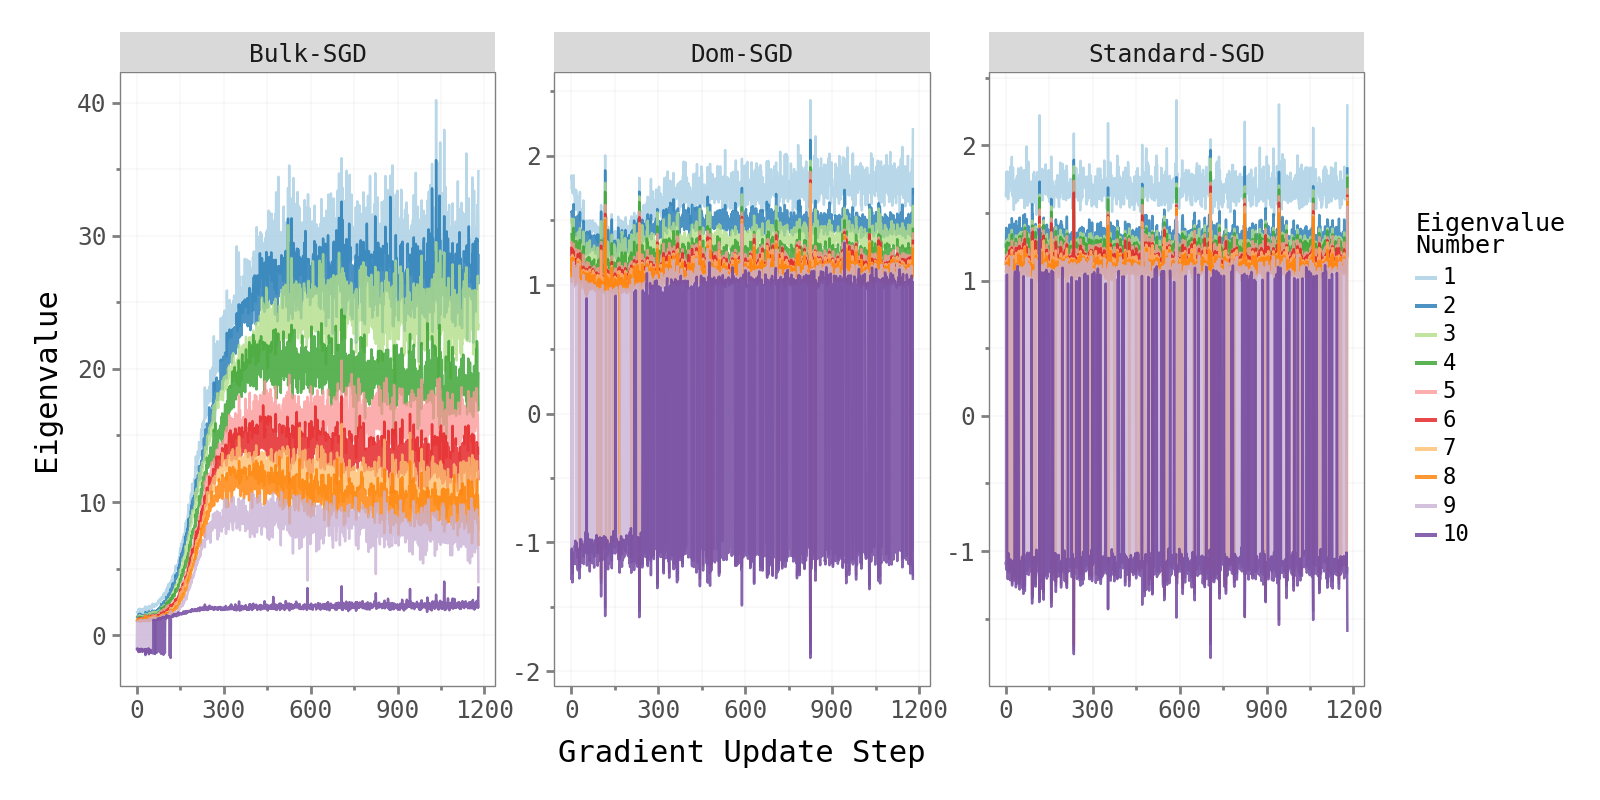

/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../results/subspace_sgd_examples/subspace_top_k_eigenvalues.pdf


In [17]:
rows = []
top_k_eigenvalues = {
    "Bulk-SGD": top_k_eigenvalues_bulk,
    "Dom-SGD": top_k_eigenvalues_dom,
    "Standard-SGD": top_k_eigenvalues_sgd,
}

# create dictionary for evolution of top k eigenvalues
for subspace_names, subspace_data in top_k_eigenvalues.items():
    step = 0
    for epoch_idx, epoch_data in enumerate(subspace_data):
        for batch_idx, eigenvalues in enumerate(epoch_data):
            for eig_idx, value in enumerate(eigenvalues):
                rows.append(
                    {
                        "step": step,
                        "subspace": subspace_names,
                        "epoch": epoch_idx,
                        "eigenvalue_number": 10 - eig_idx,
                        "eigenvalue": value,
                    }
                )
            step += 1


# Convert to dataframe for plotting
eigenvalues_df = pd.DataFrame(rows)

# Create plot
fig_eigenval = (
    pn.ggplot(
        eigenvalues_df,
        pn.aes(
            x="step",
            y="eigenvalue",
            color="factor(eigenvalue_number)",
            group="eigenvalue_number",
        ),
    )
    + pn.geom_line(size=0.5, alpha=0.8)
    + pn.scale_color_brewer(type="qual", palette=3, name="Eigenvalue\nNumber")
    + pn.facet_wrap("~subspace", scales="free_y")
    + pn.labs(
        # title="Eigenvalues Evolution Over Time",
        # subtitle="Top 10 Eigenvalues by Subspace Type",
        x="Gradient Update Step",
        y="Eigenvalue",
        color="Top-10 Eigenvalue\nNumber",
    )
    + theme_academic
)
display(fig_eigenval)

fig_eigenval.save(
    filename="../results/subspace_sgd_examples/subspace_top_k_eigenvalues.pdf",
    width=8,
    height=4,
    dpi=300,
)

### Loss and Accuracy

Finally, we plot the train loss and train accuracy over the epochs for the different SGD variants.

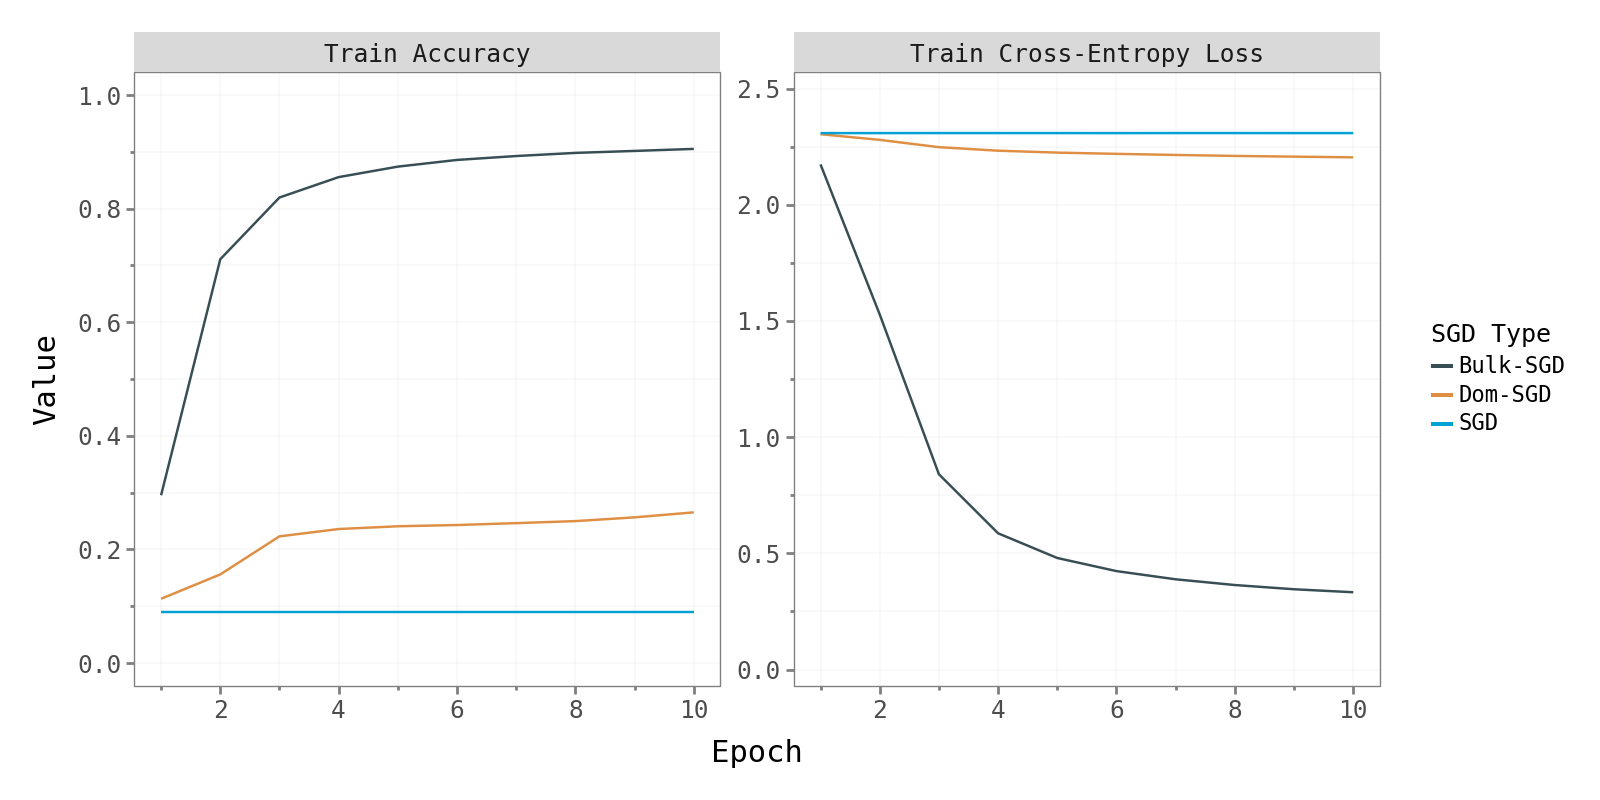

/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/home/janhsc/miniconda3/envs/cf/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../results/subspace_sgd_examples/train_metrics.pdf


In [18]:
train_losses = {
    "Bulk-SGD": train_losses_bulk,
    "Dom-SGD": train_losses_dom,
    "SGD": train_losses_sgd,
}

train_accuracies = {
    "Bulk-SGD": [acc / 100 for acc in train_accuracies_bulk],
    "Dom-SGD": [acc / 100 for acc in train_accuracies_dom],
    "SGD": [acc / 100 for acc in train_accuracies_sgd],
}

train_metrics = {
    "Train Cross-Entropy Loss": train_losses,
    "Train Accuracy": train_accuracies,
}

# create dictionary to construct dataframe from
rows = []
for metric_name, metric_data in train_metrics.items():
    for subspace_name, subspace_data in metric_data.items():
        for epoch_idx, value in enumerate(subspace_data):
            rows.append(
                {
                    "epoch": epoch_idx + 1,
                    "value": value,
                    "metric": metric_name,
                    "subspace": subspace_name,
                }
            )

# Convert to dataframe for plotting
train_metrics_df = pd.DataFrame(rows)

# Create plot
fig_train_metrics = (
    pn.ggplot(
        train_metrics_df,
        pn.aes(x="epoch", y="value", color="subspace", group="subspace"),
    )
    + pn.geom_line(size=0.5, alpha=0.8)
    + pn.scale_color_manual(values=jama_colors)
    + pn.facet_wrap("~metric", scales="free_y")
    + pn.labs(
        x="Epoch",
        y="Value",
        color="SGD Type",
    )
    + pn.scale_y_continuous(
        limits=lambda limits: (
            (0, 1) if limits[1] <= 1 else (0, 2.5)
        ),  # force limits for each metric
        breaks=lambda limits: (
            [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # breaks for accuracy
            if limits[1] <= 1.5
            else [0, 0.5, 1.0, 1.5, 2.0, 2.5]  # breaks for CE loss
        ),
        expand=(0.02, 0.02),
    )
    + pn.scale_x_continuous(
        breaks=range(0, int(train_metrics_df["epoch"].max()) + 1, 2)
    )  # Steps of 2
    + theme_academic
)

display(fig_train_metrics)

fig_train_metrics.save(
    filename="../results/subspace_sgd_examples/train_metrics.pdf",
    width=8,
    height=4,
    dpi=300,
)